Epoch 1/10


C:\Users\LIKHITH\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1196/1196 ━━━━━━━━━━━━━━━━━━━━ 2s 884us/step - accuracy: 0.9804 - loss: 0.0612
Epoch 2/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - accuracy: 0.9989 - loss: 0.0071
Epoch 3/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step - accuracy: 0.9990 - loss: 0.0060
Epoch 4/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - accuracy: 0.9988 - loss: 0.0057
Epoch 5/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 1s 888us/step - accuracy: 0.9990 - loss: 0.0045
Epoch 6/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - accuracy: 0.9993 - loss: 0.0031
Epoch 7/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - accuracy: 0.9991 - loss: 0.0031
Epoch 8/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 1s 859us/step - accuracy: 0.9992 - loss: 0.0027
Epoch 9/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 1s 873us/step - accuracy: 0.9993 - loss: 0.0024
Epoch 10/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/step - accuracy: 0.9993 - loss: 0.0020
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
Evaluating Decision Tree

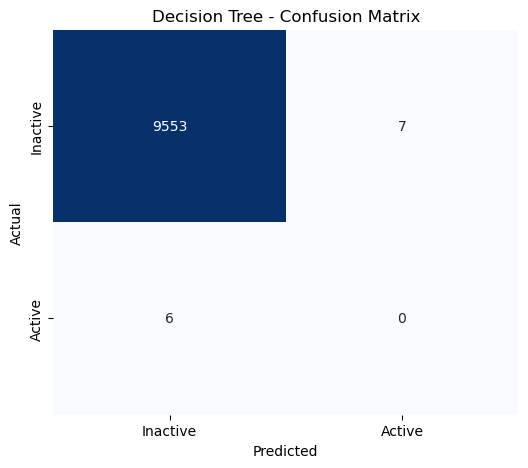

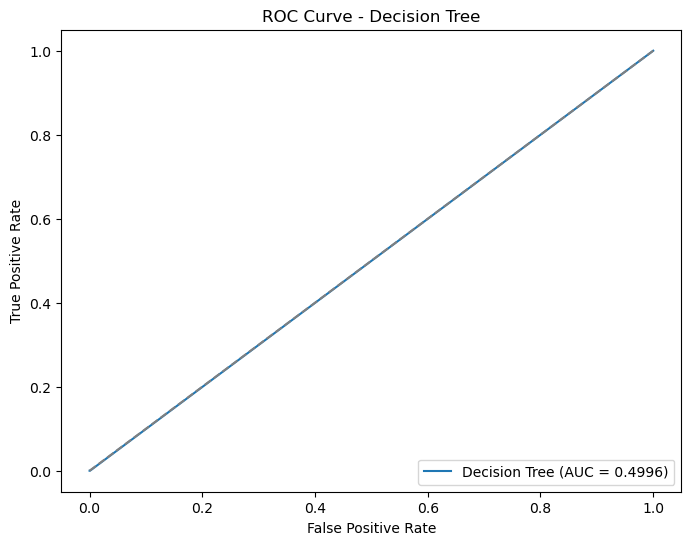

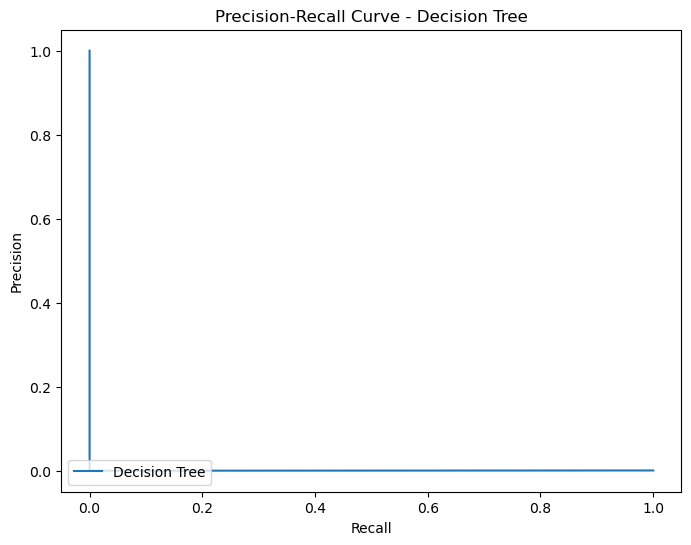

Evaluating Ridge Regression...


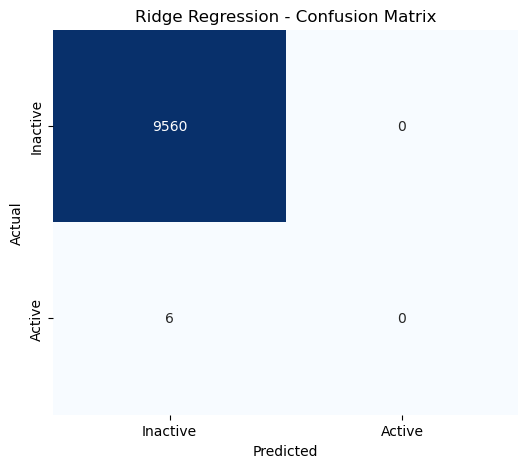

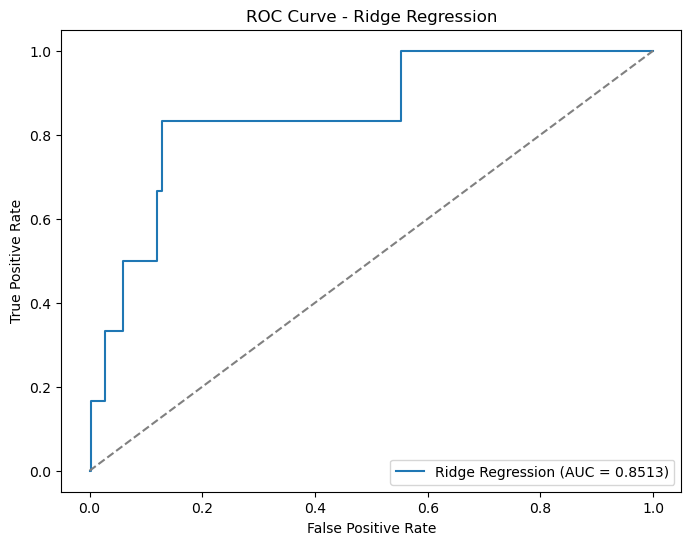

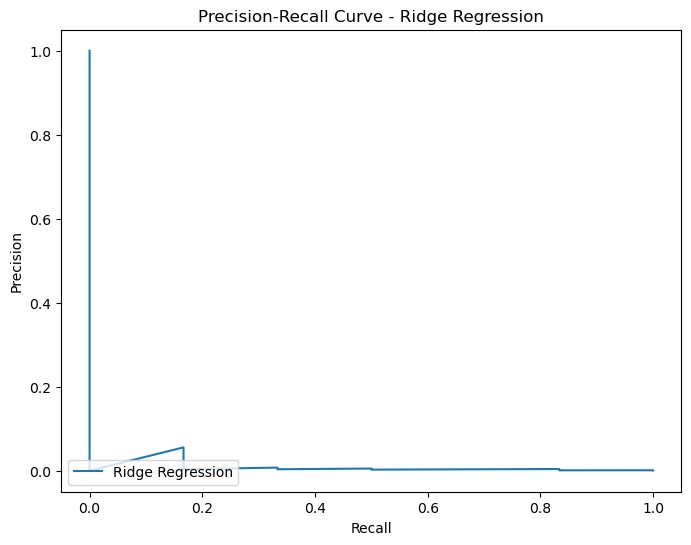

Evaluating ANN...


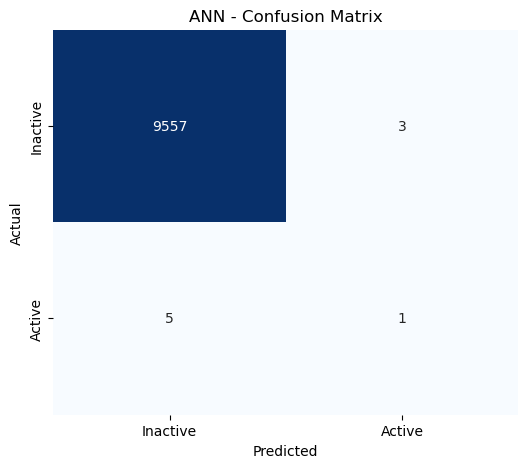

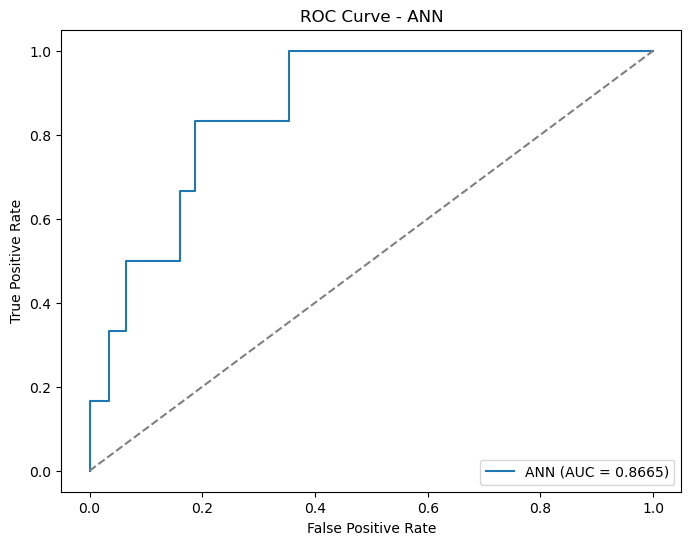

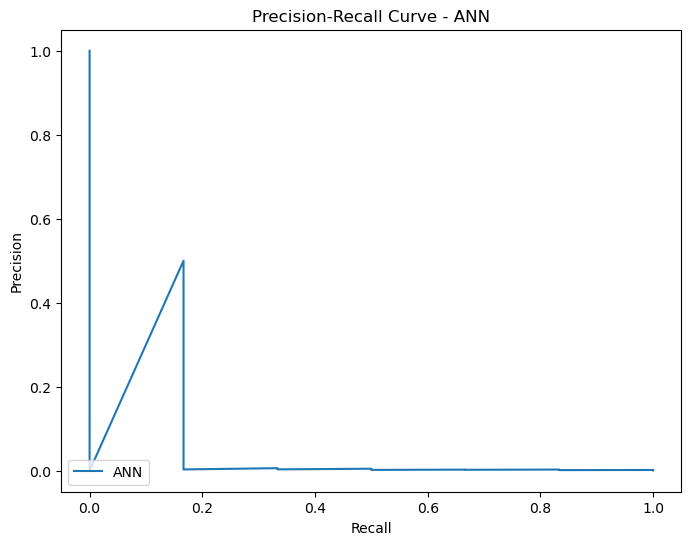

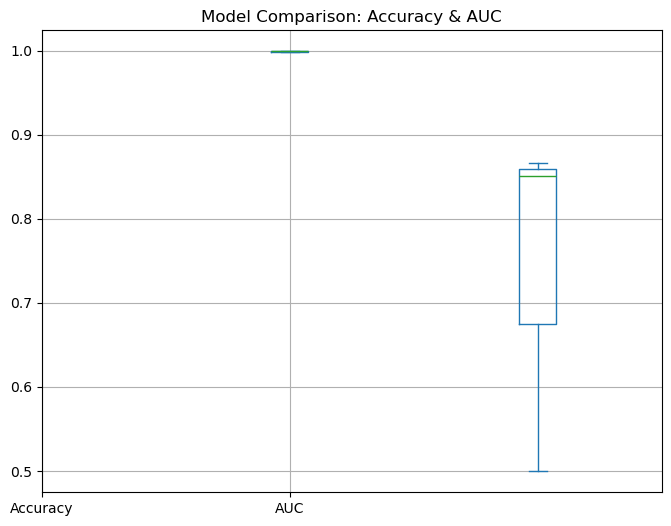

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('train.csv')  # Replace with your actual file path
target_column = 'Outcome'  # Replace with the actual target column name if different

# Check for missing values and drop them
df.dropna(inplace=True)

# Convert target to numeric (0 and 1) if it's not already
df[target_column] = df[target_column].apply(lambda x: 1 if x == 'Active' else 0)

# Define features and target
X = df.drop(columns=[target_column])
y = df[target_column]

# Ensure all features are numeric (if not already)
X = X.apply(pd.to_numeric, errors='coerce')

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize models
dt = DecisionTreeClassifier()
ridge = RidgeClassifier()
ann = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Train models
dt.fit(X_train, y_train)
ridge.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt.predict(X_test)
y_pred_ridge = ridge.predict(X_test)
y_pred_ann = (ann.predict(X_test) > 0.5).astype("int32")

# Get predicted probabilities for ROC and Precision-Recall curves
y_pred_dt_prob = dt.predict_proba(X_test)[:, 1]

# For RidgeClassifier, use decision_function to get confidence scores
y_pred_ridge_prob = ridge.decision_function(X_test)
y_pred_ann_prob = ann.predict(X_test)

# Evaluate function for plotting
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Inactive', 'Active'], yticklabels=['Inactive', 'Active'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def plot_roc_curve(y_true, y_pred_prob, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc_score = roc_auc_score(y_true, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title(f'ROC Curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

def plot_precision_recall_curve(y_true, y_pred_prob, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'{model_name}')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.show()

def plot_model_comparison(models_performance):
    # Boxplot to compare accuracy and AUC
    metrics = ['Accuracy', 'AUC']
    results = []

    for model, performance in models_performance.items():
        results.append([model, performance['accuracy'], performance['auc']])

    results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'AUC'])

    # Plotting boxplot
    results_df.plot(kind='box', figsize=(8, 6), grid=True, title='Model Comparison: Accuracy & AUC')
    plt.xticks([0, 1], ['Accuracy', 'AUC'])
    plt.show()

# Evaluate models and plot their performance
def evaluate_and_plot(model_name, y_true, y_pred, y_pred_prob):
    print(f"Evaluating {model_name}...")
    plot_confusion_matrix(y_true, y_pred, model_name)
    plot_roc_curve(y_true, y_pred_prob, model_name)
    plot_precision_recall_curve(y_true, y_pred_prob, model_name)

# Main function to execute everything
def main():
    # Evaluate Decision Tree
    evaluate_and_plot("Decision Tree", y_test, y_pred_dt, y_pred_dt_prob)

    # Evaluate Ridge Regression
    evaluate_and_plot("Ridge Regression", y_test, y_pred_ridge, y_pred_ridge_prob)

    # Evaluate ANN
    evaluate_and_plot("ANN", y_test, y_pred_ann, y_pred_ann_prob)

    # Model comparison plot
    models_performance = {
        "Decision Tree": {"accuracy": accuracy_score(y_test, y_pred_dt), "auc": roc_auc_score(y_test, y_pred_dt_prob)},
        "Ridge Regression": {"accuracy": accuracy_score(y_test, y_pred_ridge), "auc": roc_auc_score(y_test, y_pred_ridge_prob)},
        "ANN": {"accuracy": accuracy_score(y_test, y_pred_ann), "auc": roc_auc_score(y_test, y_pred_ann_prob)},
    }
    plot_model_comparison(models_performance)

# Execute main function
if __name__ == "__main__":
    main()
